# Milestone 3 - Fictional worlds analysis
...

In [3]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

# Import extra functions and datasets

In [25]:
import preprocessing
import topic_modeling

In [4]:
folder_path = os.path.abspath('MovieSummaries')
df_movies, df_summaries = preprocessing.get_datasets(folderpath=folder_path)

In [48]:
df_genres = preprocessing.get_movie_genres_dataframe(df_movies=df_movies)
df_fictional_summaries, df_fictional = preprocessing.get_fictional_summaries_subset(df_genres=df_genres, df_movies=df_movies, df_summaries=df_summaries, return_df_fictional=True)

   Wikipedia_movie_ID Freebase_genre_ID      movie_genre
0              975900         /m/01jfsb         Thriller
1              975900          /m/06n90  Science Fiction
2              975900          /m/03npn           Horror
3              975900         /m/03k9fj        Adventure
4              975900          /m/0fdjb     Supernatural
The total number of movies referred to as fictional is 5366, corresponding to 6.56% of whole movies.


In [6]:
imdb_title_genre_df = pd.read_table("Dataset/IMDB/title.basics.tsv/data.tsv", delimiter='\t')

C:\Users\gezas\AppData\Local\Temp\ipykernel_10456\949645751.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb_title_genre_df = pd.read_table("Dataset/IMDB/title.basics.tsv/data.tsv", delimiter='\t')


# Getting the subset of movies with genre "science-fiction" or "fantasy"
This approach is based on CMU genres combined with IMDB genre metadata

In [43]:
# remove movies without genre given
df_imdb_movie_genred = imdb_title_genre_df[~imdb_title_genre_df['genres'].isna()]
# Select rows where "Sci-Fi" or "Fantasy" appear in genres
df_imdb_fictional = df_imdb_movie_genred[df_imdb_movie_genred['genres'].str.contains('Sci-Fi|Fantasy', case=False, regex=True)]
# The full dataset from imdb
df_imdb_fictional.shape

(312105, 9)

In [45]:
df_fictional_cmu_imdb = pd.merge(df_movies,
                              df_imdb_fictional[[ 'tconst', 'titleType', 'isAdult', 'primaryTitle', 'originalTitle', 'startYear', 'genres']],
                              left_on='movie_name', right_on='primaryTitle', how='inner', suffixes = ['CMU', 'IMDB'])
# Get summaries from movies that are genred as fictional in IMDB
df_fictional_summaries_idmb = df_summaries[df_summaries['Wikipedia_movie_ID'].isin(df_fictional_cmu_imdb['Wikipedia_movie_ID'])]

In [68]:
#movie_metadata_of_interest = ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'movie_name', 'movie_release_date', 'movie_box_office_revenu', 'movie_runtime', 'movie_genres', 'tconst', 'titleType', 'isAdult', 'primaryTitle', 'originalTitle', 'startYear', 'genres']
movie_metadata_of_interest = ['Wikipedia_movie_ID','movie_name','movie_release_date', 'movie_box_office_revenu', 'movie_runtime']
# Merge with movies to have more information related to each summary
df_fictional = pd.merge(df_fictional_summaries, df_movies[movie_metadata_of_interest], on='Wikipedia_movie_ID')
df_fictional_idmb = pd.merge(df_fictional_summaries_idmb, df_movies[movie_metadata_of_interest], on='Wikipedia_movie_ID')
# Find year based on cmu release date info (could be found also with imdb)
df_fictional['release_year'] = pd.to_datetime(df_fictional['movie_release_date'], format='mixed', errors='coerce').dt.year
df_fictional_idmb['release_year'] = pd.to_datetime(df_fictional_idmb['movie_release_date'], format='mixed', errors='coerce').dt.year

In [69]:
# Merge all summaries that have at least be found to be referenced as science fiction or fantasy in one of the datasets
df_fictional_summaries_all = pd.concat((df_fictional, df_fictional_idmb)).drop_duplicates('Wikipedia_movie_ID', keep='first')
print(df_fictional_summaries_all.shape)

(10871, 7)


In [70]:
df_fictional_summaries_all.head()

,Wikipedia_movie_ID,movie_summary,movie_name,movie_release_date,movie_box_office_revenu,movie_runtime,release_year
0,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,2012-03-12,686533290.0,142.0,2012.0
1,1838882,"The evil Lord Conqueror, head of Conqueror's C...",The Storm Riders,1998,NaN,130.0,1998.0
2,4466226,During the Great depression in 1933 in Winnipe...,The Saddest Music in the World,2003-09-07,NaN,100.0,2003.0
3,657446,"In Los Angeles, California Fletcher Reede is ...",Liar Liar,1997-03-21,302710615.0,86.0,1997.0
4,32163620,"In the winter of 1945, immediately after the l...",Gates of the Night,1946-12-03,NaN,120.0,1946.0


# Visually exploring the subset of summaries

Text(0.5, 1.0, 'Count of movie summaries classified as fictional per year')

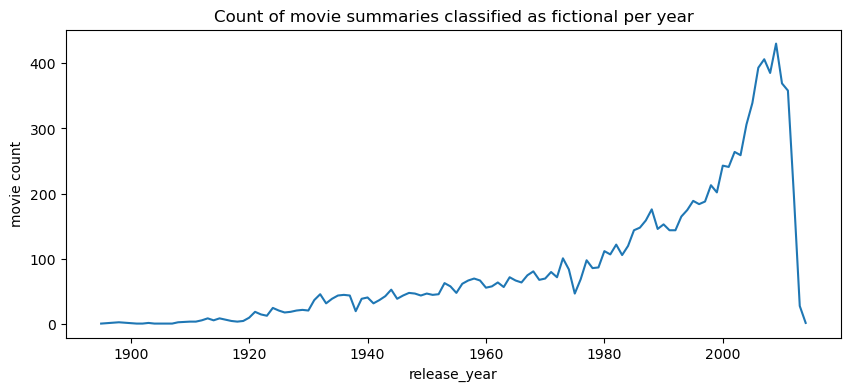

In [94]:
plt.figure(figsize=(10,4))
sns.lineplot(df_fictional_summaries_all.groupby('release_year')['Wikipedia_movie_ID'].agg("count"))
plt.ylabel('movie count')
plt.title('Count of movie summaries classified as fictional per year')

# Topic Modelling

In [95]:
from tqdm import tqdm

# natural language processing
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
import spacy

# topic modelling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

nlp = spacy.load("en_core_web_sm")

## i) Preprocess the summaries
Preprocessing the summaries involves, via tokenization, removing stop words and proper noun and taking only the lemma of each word.

In [75]:
docs = df_fictional_summaries_all['movie_summary']
result_array = []
for doc in tqdm(nlp.pipe(docs, disable=["parser", "textcat"], batch_size=100, n_process=-1)):
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop and token.pos_ not in ['PROPN']]
    result_array.append(" ".join(tokens))

0it [00:00, ?it/s]

10871it [02:20, 77.12it/s] 


In [77]:
df_fictional_summaries_all['preprocessed_summary'] = result_array
df_fictional_summaries_all.head()

,Wikipedia_movie_ID,movie_summary,movie_name,movie_release_date,movie_box_office_revenu,movie_runtime,release_year,preprocessed_summary
0,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,2012-03-12,686533290.0,142.0,2012.0,nation consist wealthy poor district punishmen...
1,1838882,"The evil Lord Conqueror, head of Conqueror's C...",The Storm Riders,1998,NaN,130.0,1998.0,evil head give prophecy say find young child g...
2,4466226,During the Great depression in 1933 in Winnipe...,The Saddest Music in the World,2003-09-07,NaN,100.0,2003.0,great depression old fortune teller predict fu...
3,657446,"In Los Angeles, California Fletcher Reede is ...",Liar Liar,1997-03-21,302710615.0,86.0,1997.0,career focus lawyer divorced father love spend...
4,32163620,"In the winter of 1945, immediately after the l...",Gates of the Night,1946-12-03,NaN,120.0,1946.0,winter immediately liberation member french un...


In [78]:
if False:
    df_fictional_summaries_all.to_csv('df_summaries_preprocessed_all.csv')
if False:
    df_fictional_summaries_all = pd.read_csv('df_summaries_preprocessed_all.csv')

In [106]:
vectorizer10 = CountVectorizer(min_df=10)
dtm10 = vectorizer10.fit_transform(df_fictional_summaries_all['preprocessed_summary'])
df_fictional_summaries_all['wordcount_min10freq'] = np.sum(dtm10, axis = 1)

In [107]:
df_fictional_summaries_all

,Wikipedia_movie_ID,movie_summary,movie_name,movie_release_date,movie_box_office_revenu,movie_runtime,release_year,preprocessed_summary,wordcount_min5freq,wordcount_min10freq
0,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,2012-03-12,686533290.0,142.0,2012.0,nation consist wealthy poor district punishmen...,297,297
1,1838882,"The evil Lord Conqueror, head of Conqueror's C...",The Storm Riders,1998,NaN,130.0,1998.0,evil head give prophecy say find young child g...,118,117
2,4466226,During the Great depression in 1933 in Winnipe...,The Saddest Music in the World,2003-09-07,NaN,100.0,2003.0,great depression old fortune teller predict fu...,264,256
3,657446,"In Los Angeles, California Fletcher Reede is ...",Liar Liar,1997-03-21,302710615.0,86.0,1997.0,career focus lawyer divorced father love spend...,250,245
4,32163620,"In the winter of 1945, immediately after the l...",Gates of the Night,1946-12-03,NaN,120.0,1946.0,winter immediately liberation member french un...,45,45
...,...,...,...,...,...,...,...,...,...,...
9551,24211707,The film follows a United States Border Patrol...,Borderline,1980-10-31,NaN,99.0,1980.0,film follow force track killer young mexican b...,592,582
9555,13348400,Jennie Lee is the lead singer of an all-girl ...,Satisfaction,1988-02-12,8253123.0,92.0,1988.0,lead singer girl rock band name high school gr...,287,285
9556,277160,"Virginia ""Gin"" Baker is an investigator for W...",Entrapment,1999-04-30,212404396.0,113.0,1999.0,investigator international art thief priceless...,163,162
9558,17736697,Paula Eastman is a Hollywood actress with an ...,Torch Song,1993-05-23,NaN,89.0,1993.0,actress alcohol problem career poorly sleep ac...,54,54


<Axes: xlabel='release_year', ylabel='wordcount_min10freq'>

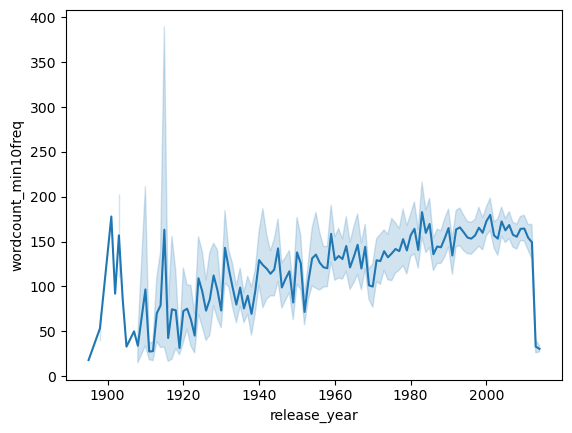

In [109]:
plt.figure()
sns.lineplot(data=df_fictional_summaries_all.reset_index() , x = 'release_year', y = 'wordcount_min10freq')

## ii) LDA topic modelling

In [111]:
# Define function to show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda, n_words=10):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords


iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,kill,attack,body,house,leave,escape,try,head,go,run
Topic 1,kill,village,man,attack,battle,fight,take,soldier,castle,evil
Topic 2,get,car,money,go,tell,game,leave,time,try,play
Topic 3,tell,leave,man,go,woman,house,home,see,wife,take
Topic 4,kill,police,man,escape,shoot,murder,fight,take,gang,order
Topic 5,alien,destroy,human,planet,ship,attack,discover,power,space,scientist
Topic 6,love,father,family,mother,child,life,tell,friend,return,year
Topic 7,ship,escape,leave,water,island,try,take,boat,away,man
Topic 8,film,story,world,life,character,movie,time,begin,people,young
Topic 9,school,student,teacher,ghost,high,class,college,dragon,friend,professor


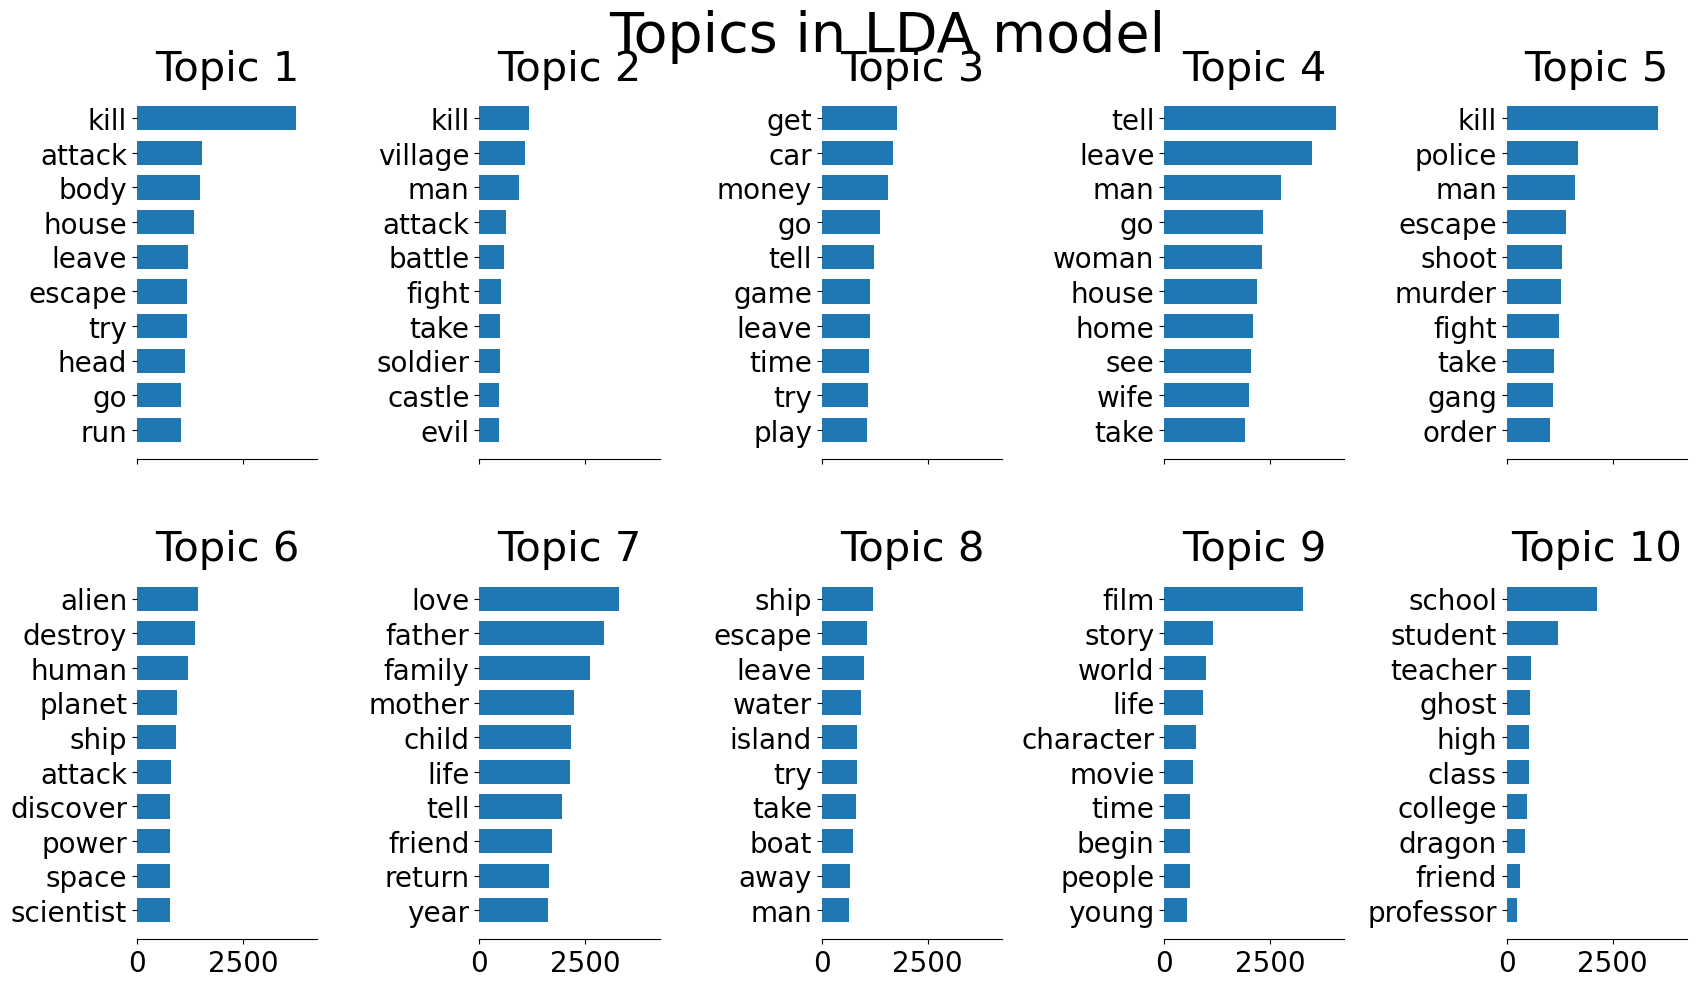

In [112]:
# Vectorize the summaries
vectorizer = CountVectorizer(max_df=0.50, min_df=10, max_features=n_features)
#vectorizer = TfidfVectorizer(stop_words='english', max_df=0.75, min_df=10, max_features=n_features)
dtm = vectorizer.fit_transform(df_fictional_summaries_all['preprocessed_summary'])

# normalize per row
#transformer = Normalizer(norm='max').fit(dtm)
#dtm_normalized = transformer.transform(dtm)

In [ ]:

# General parameters to adapt
n_features = 3000
n_topics = 10
n_top_words = 10
alpha = None
# doc_topic_prior:=alpha : represents the parameter of the Dirichlet prior on the per-document topic distributions. It influences how many topics are likely to be present in a document.
    # Higher alpha values result in documents with more topics, while lower values lead to sparser documents with fewer dominant topics.
beta = None
# topic_word_prior := beta : represents the parameter of the Dirichlet prior on the per-topic word distributions. It controls the number of words associated with each topic.
#Similar to alpha, higher beta values result in topics with more words, while lower values lead to sparser topics.


# Create the LatentDirichletAllocation model
lda = LatentDirichletAllocation(
    n_components=n_topics,
    doc_topic_prior= alpha, 
    topic_word_prior= beta,
    learning_method = 'online',
    learning_offset= 50,
    learning_decay=0.8,
    max_iter=10,
    random_state=7,
    verbose=1
)


lda.fit(dtm)
#lda.fit(dtm_normalized)

# Show the topics with their n_top words in a DataFrame form
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda, n_words=n_top_words)
df_topic_keywords = pd.DataFrame(topic_keywords)

# Improve comprehension with adapted column and index names
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
display(df_topic_keywords)

# Plot the top n words for all topics
tf_feature_names = vectorizer.get_feature_names_out()
topic_modeling.plot_top_words(lda, tf_feature_names, 10, n_topics=n_topics, title="Topics in LDA model")

# takes around 1min30 with 2000 features